# Teaching an Artificial Intelligence to Play Tic-Tac-Toe

Artificial intelligence (AI) is typically used as a decision making tool or aid. For developing systems that can make informed decisions, board games provide good benchmarks. Advances in AI methodology (not just the speed of computers!) has brought us to a point where game-playing AIs can beat human players not only in **Chess** but also in **Shogi** and **Go** [1]. However, this is narrow artificial intelligence, methods trained for a specific purpose and that do not directly generalize to other tasks. For example, the example code below will not learn to drive a car or cook dinner however much you show it driving or cooking.

This exercise is modified from a course exercise on the course *Introduction to Articial Intelligence* lectured by Prof. [Arno Solin](http://arno.solin.fi). The course is open to students across *all disciplines* in [Aalto University](https://www.aalto.fi/en), ranging from arts to theoretical physics. Therefore it does not require any prior skills in programming or mathematics.

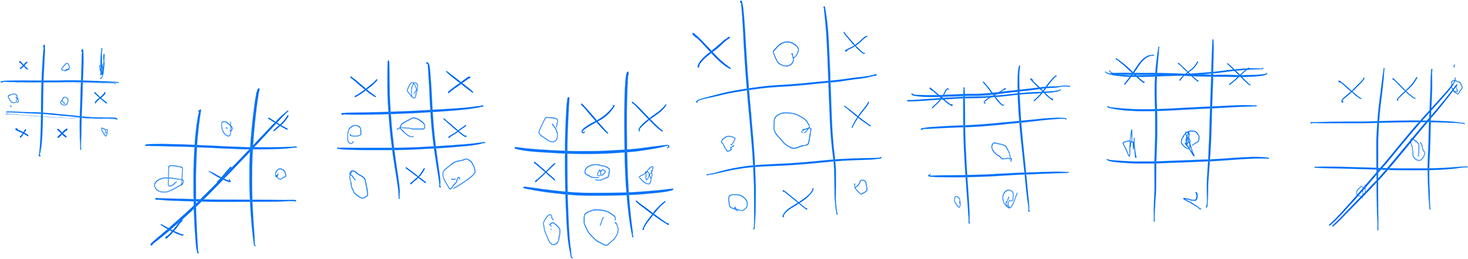

## Reinforcement learning for game play

In this exercise, you get to train a game-playing AI from scratch for the classic game of Tic-Tac-Toe (also known as Noughts and Crosses) [2]. We consider the simplest version of the game, where only a `3x3` grid is used. The AI will know the hard-coded rules of the game, but simply knowing the rules does not make the AI great at playing. One option would be to show the AI a lot of human-played games as *training data*, but instead we employ a method called *reinforcement learning* (RL). We will put the RL agent to play games agaist itself such that it learns how to play the game efficiently.

Here, the goal is to learn a policy (what to do), which tells the game-playing agent what action to take under what circumstances (depending on where the opponent puts their mark). It can learn purely by self-play once it has been given the rules of the game. The agent will receive a reward of `+1` if it wins and `-1` if it loses a game. We use a modified implementation following [3], and all code needed for this task is presented below.

#### References

[1] Steven Strogatz (2018). One Giant Step for a Chess-Playing Machine. [New York Times](https://www.nytimes.com/2018/12/26/science/chess-artificial-intelligence.html)

[2] Tic-tac-toe. In Wikipedia, The Free Encyclopedia. URL: https://en.wikipedia.org/wiki/Tic-tac-toe

[3] Neil Slater (2017). Game Playing Script(s). URL: https://github.com/neilslater/game_playing_scripts

## Task 1. Setup methods
This exercise is coded in the Python programming language. You will see all the code, mostly to show that artificial intelligence is not any sort of alchemy, but rather simple, yet clever algorithms. Run the code below to set up our reinforcement learnning framework for Tic-Tac-Toe.
### Utility Code

In [ ]:
'''
   Copyright 2017 Neil Slater
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at
       http://www.apache.org/licenses/LICENSE-2.0
   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
   
   The original code as been modified for educatonal purposes.
'''

import numpy as np
import random

class TicTacToeGame():
    def __init__(self):
        self.state = '         '  #a string of length 9 that encode the state of the 3*3 board 
        self.player = 'X'
        self.winner = None

    def allowed_moves(self):      #find the empty position in the state string 
        states = []               #store all possible next states
        for i in range(len(self.state)):
            if self.state[i] == ' ':
                states.append(self.state[:i] + self.player + self.state[i+1:]) 
        return states

    def make_move(self, next_state):
        if self.winner:
            raise(Exception("Game already completed, cannot make another move!"))
        if not self.__valid_move(next_state):
            raise(Exception("Cannot make move {} to {} for player {}".format(
                    self.state, next_state, self.player)))

        self.state = next_state
        self.winner = self.predict_winner(self.state)
        if self.winner:
            self.player = None
        elif self.player == 'X':
            self.player = 'O'
        else:
            self.player = 'X'

    def playable(self):
        return ( (not self.winner) and any(self.allowed_moves()) )

    def predict_winner(self, state):
        lines = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]  # all possible lines
        winner = None
        for line in lines:
            line_state = state[line[0]] + state[line[1]] + state[line[2]]
            if line_state == 'XXX':
                winner = 'X'
            elif line_state == 'OOO':
                winner = 'O'
        return winner

    def __valid_move(self, next_state):
        allowed_moves = self.allowed_moves()  #get all possible next states
        if any(state == next_state for state in allowed_moves): #check if the input next_state is in 
            return True
        return False

    def print_board(self):
        s = self.state
        print('     {} | {} | {} '.format(s[0],s[1],s[2]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[3],s[4],s[5]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[6],s[7],s[8]))


class Agent():
    def __init__(self, game_class, epsilon=0.1, alpha=0.5, value_player='X'):
        self.V = dict()  #dictionary to store value
        self.NewGame = game_class
        self.epsilon = epsilon
        self.alpha = alpha
        self.value_player = value_player

    def state_value(self, game_state):
        return self.V.get(game_state, 0.0)

    def learn_game(self, num_episodes=1000):
        for episode in range(num_episodes):
            self.learn_from_episode()

    def learn_from_episode(self):
        game = self.NewGame()
        _, move = self.learn_select_move(game)
        while move:
            move = self.learn_from_move(game, move)



    def learn_from_move(self, game, move):
        game.make_move(move)
        r = self.__reward(game)   
        td_target = r
        next_state_value = 0.0
        selected_next_move = None
        if game.playable():
            best_next_move, selected_next_move = self.learn_select_move(game)
            next_state_value = self.state_value(best_next_move)
        current_state_value = self.state_value(move)
        td_target = r + next_state_value
        self.V[move] = current_state_value + self.alpha * (td_target - current_state_value)  #update value 
        return selected_next_move

    def learn_select_move(self, game):
        allowed_state_values = self.__state_values( game.allowed_moves() )
        if game.player == self.value_player:
            best_move = self.__argmax_V(allowed_state_values)
        else:
            best_move = self.__argmin_V(allowed_state_values)

        selected_move = best_move
        if random.random() < self.epsilon:  #epsilon-greedy strategy 
            selected_move = self.__random_V(allowed_state_values)

        return (best_move, selected_move)

    def play_select_move(self, game):
        allowed_state_values = self.__state_values( game.allowed_moves() )
        if game.player == self.value_player:
            return self.__argmax_V(allowed_state_values)
        else:
            #return self.__argmin_V(allowed_state_values)
            return self.__random_V(allowed_state_values)

    def demo_game(self, verbose=False):
        game = self.NewGame()
        t = 0
        while game.playable():
            if verbose:
                print(" \nTurn {}\n".format(t))
                game.print_board()
            move = self.play_select_move(game)
            game.make_move(move)
            t += 1
        if verbose:
            print(" \nTurn {}\n".format(t))
            game.print_board()
        if game.winner:
            if verbose:
                print("\n{} is the winner!".format(game.winner))
            return game.winner
        else:
            if verbose:
                print("\nIt's a draw!")
            return '-'

    def interactive_game(self, agent_player='X'):
        game = self.NewGame()
        t = 0
        while game.playable():
            print(" \nTurn {}\n".format(t))
            game.print_board()
            if game.player == agent_player:
                move = self.play_select_move(game)
                game.make_move(move)
            else:
                move = self.__request_human_move(game)
                game.make_move(move)
            t += 1

        print(" \nTurn {}\n".format(t))
        game.print_board()

        if game.winner:
            print("\n{} is the winner!".format(game.winner))
            return game.winner
        print("\nIt's a draw!")
        return '-'

    def round_V(self):
        # After training, this makes action selection random from equally-good choices
        for k in self.V.keys():
            self.V[k] = round(self.V[k],1)


    def __state_values(self, game_states):
        return dict((state, self.state_value(state)) for state in game_states)

    def __argmax_V(self, state_values):
        max_V = max(state_values.values())
        chosen_state = random.choice([state for state, v in state_values.items() if v == max_V])
        return chosen_state

    def __argmin_V(self, state_values):
        min_V = min(state_values.values())
        chosen_state = random.choice([state for state, v in state_values.items() if v == min_V])
        return chosen_state

    def __random_V(self, state_values):
        return random.choice(list(state_values.keys()))

    def __reward(self, game):
        if game.winner == self.value_player:
            return 1.0
        elif game.winner:
            return -1.0
        else:
            return 0.0

    def __request_human_move(self, game):
        allowed_moves = [i+1 for i in range(9) if game.state[i] == ' ']
        human_move = None
        while not human_move:
            idx = int(input('Choose move for {}, from {} : '.format(game.player, allowed_moves)))
            if any([i==idx for i in allowed_moves]):
                human_move = game.state[:idx-1] + game.player + game.state[idx:]
        return human_move

def demo_game_stats(agent):
    results = [agent.demo_game() for i in range(10000)]
    game_stats = {k: results.count(k)/100 for k in ['X', 'O', '-']}
    print("    percentage results: {}".format(game_stats))



## Task 2. Make an agent
Now it is time to create your game-playing AI agent. Here you choose name for it (`O`/`X` note that `X` always starts) and set the learning-rate parameter epsilon and discount factor for discounting future rewards (controlling how fast the agent learns from experience). We also print out some test stats of the efficiency of this AI before learning (NB: '`-`' stands for a draw). Evaluate the cell below to create the agent and see some preliminary statistics before training your agent.

In [ ]:
# Create you agent (named 'X') and assign the learning rate and discount factor
agent = Agent(TicTacToeGame, epsilon = 0.1, alpha = 0.5, value_player='X')

print("Before learning:")
demo_game_stats(agent)


## Task 3. Play against your agent
Try out how well your agent works. You can play interactive games against the agent by running the cell below. The AI will ask you for your next move and then proceed to make its move. The moves are given by indicating which cell you want to put your mark in:
```
     1 | 2 | 3 
    -----------
     4 | 5 | 6 
    -----------
     7 | 8 | 9 
 ```
 Play a couple of games (you should be able to win quite easily...)

In [ ]:
agent.interactive_game()

## Task 4. Train the agent through self-play
You can have the agent play against itself for a number of games in order to learn how to play the game. In the cell below you will make the agent play 1000 games. After that, try playing against it again. Can you see any difference?

In [ ]:
agent.learn_game(1000)
print("After 1000 learning games:")
demo_game_stats(agent)

In [ ]:
agent.interactive_game()

## Task 5. More training and playing
Continue training the method:
* For 4000 more games, then try playing again. 

What do you notice? Is the agent getting harder to beat? You can re-evaluate the cell below to have the AI train more.

In [ ]:
agent.learn_game(4000)
print("After 4000 more games:")
demo_game_stats(agent)

In [ ]:
agent.interactive_game()

## Optional: Tweak the model
Now you can tweak the model, and experiment further:
* Start by changing the AI identity to '`O`' (so that you get to start the games). Re-train and re-try playing.
* You can also experiment with changing the learning rate and discounting factors.

## Acknowledgements
This demo was set up by [Aalto University](https://www.aalto.fi/en/) and [CSC – IT Center for Science](https://www.csc.fi/home) by request from the Finnish Ministry of Education and Culture.

Special thanks to Sami Laine (Aalto CS IT), Aleksi Kallio (CSC), and Yuxin Hou (Aalto CS). The Q-learning framework used in the demo is based on [Game Playing Script(s)](https://github.com/neilslater/game_playing_scripts) by Neil Slater. 

The computing environment is provided by [CSC – IT Center for Science](https://www.csc.fi/home). They are known for their supercomputers, but also provide comprehensive scientific computing, data management, analysis and research administration solutions as well as training and expert support. One of the pan-European EuroHPC pre-exascale supercomputers, LUMI, will be located in CSC's datacenter in Kajaani, Finland. CSC is owned by Finnish state and universities, working to help our customers thrive and to benefit society at large. 